# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 9. Байесовские классификаторы.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image`;
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.



**Баллы за задание:**

* Задача 1 &mdash; 30 баллов
* Задача 2 &mdash; 28 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import linalg
import scipy.stats as sps

sns.set(font_scale=1.2)
%matplotlib inline

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/h4zzkr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/h4zzkr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/h4zzkr/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Перед выполнением задания обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/estimators.html">ноутбук</a> с занятия по оценкам параметров.

---
# Задача 1.

На занятии мы уже научились классифицировать текстовые сообщения на нормальные и спам. Теперь перед вами стоит более серьезная задача &mdash; построить систему, автоматически классифицирующую поступающие новостные сюжеты на несколько заранее заданных категорий.
 
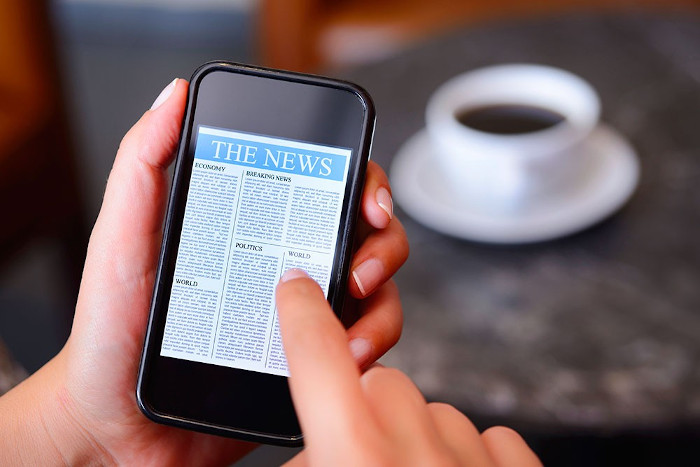



Перед выполнением задачи обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/bayes_classification.html">ноутбук</a> с занятия по классификации.

---

С помощью кода ниже загрузите встроенные в `sklearn` <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups">данные</a>, в которых представлены различные новостные сюжеты, разделенные на 20 тематических групп.

In [3]:
# удаляем заголовки и подписи
remove = ('headers', 'footers')
# зафиксируем зерно случайности
random_state = 42

# Извлекаем обучающую и тестовую части перемешивая случайным образом
data_train = fetch_20newsgroups(
    subset='train', shuffle=True, random_state=random_state, remove=remove
)
data_test = fetch_20newsgroups(
    subset='test', shuffle=True, random_state=random_state, remove=remove
)

Посмотрим на какое-нибудь сообщение

In [4]:
print(data_train['data'][21])

In article <1993Apr20.151818.4319@samba.oit.unc.edu> Scott.Marks@launchpad.unc.edu (Scott Marks) writes:
>>And of course, Mike Ramsey was (at one time) the captain in Buffalo prior to
>>being traded to Pittsburgh.  Currently, the Penguins have 3 former captains
>>and 1 real captain (Lemieux) playing for them.  They rotate the A's during the
>>season (and even the C while Mario was out).  Even Troy Loney has worn the C
>>for the Pens.
>

I think that Mike Foligno was the captain of the Sabres when he
got traded to the Leafs. Also, wasn't Rick Vaive the captain of
the Leafs when he got traded to Chicago (with Steve Thomas for
Ed Olcyzk and someone). Speaking of the Leafs, I believe that
Darryl Sittler was their captain (he'd torn the "C" off his
jersey but I think he re-claimed the captaincy later on) when he
was traded to the Flyers.

Oh yeah, of course, Gretzky was the captain of the Oilers before
he was traded wasn't he? 


Индекс тематической группы для каждого сообщения

In [5]:
data_train.target

array([7, 4, 4, ..., 3, 1, 8])

Названия тематических групп

In [6]:
data_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

С помощью методов, изученных в рамках нашего курса, постройте классификатор новостных сюжетов на тематические группы. При построении классификатора **запрещено пользоваться тестовой выборкой**. Для настройки классификатора, например, выбора оптимальных гиперпараметров, можно разделить обучающую выборку на две части &mdash; непосредственно обучающую и валидационную. Первую часть использовать для непосредственного обучения, а вторую &mdash; для настройки, пытаясь по ней оптимизировать качество.

## Предобработка текстовых данных

In [18]:
def get_df(data):
    df = pd.DataFrame(data.data)
    df.columns = ['data'] + df.columns.tolist()[1:]
    df['target'] = pd.Series(data.target)
    return df

df = get_df(data_train)

/home/h4zzkr/mipt/ida/ds/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Распределение данных по лейблам')

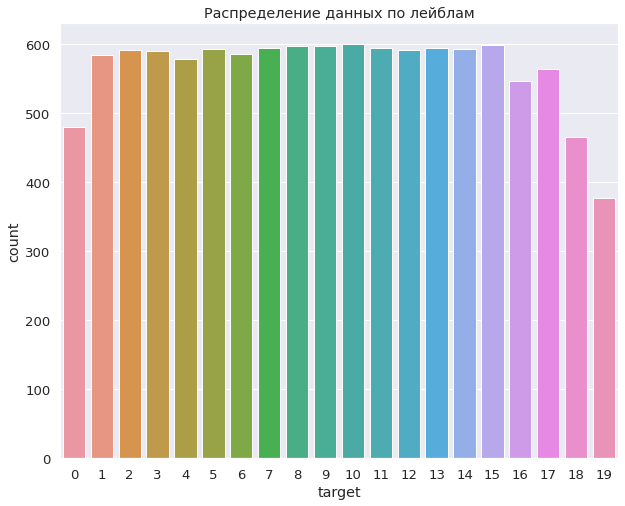

In [8]:
fig = plt.figure(figsize=(10, 8))
sns.countplot(df.target)
plt.title("Распределение данных по лейблам")

В принципе, выравнивать данные не нужно, существенного дисбаланса классов не наблюдается (кроме 18-19 и 0, но попробуем обучиться)

Будем чистить данные с помощью nltk и re. Посмотрите, как ужасен формат данных:

In [9]:
df.iloc[55].data

"I sent a response to the White House at\n\n\t0005895485@MCIMAIL.COM (White House)\n\nand received a nice, automatic reply from MICMAIL noting, in passing, that\nif I had included a SNail address, I would get a reply in due course.\n\nFor those who care, my reply was:\n\n\t1.\tyes, let's protect the voice network\n\n\t2.\tprivately-developed crypto has always been available and\n\t\talways will be -- so let's think about how to do law\n\t\tenforcement given that fact not about how to hope to\n\t\tlegislate against it\n\n\t3.\tmy needs for crypto as a system designer are not met by the\n\t\tClipper Chip.  I want freely to export uses of algorithms\n\t\t(like DES & RSA) which are already freely available in the\n\t\tdestination country\n"

- Я хочу избавиться от служебных символов, пунктуации и почт (заменить их на заглушки). Мы заменяем почту, потому что классификатор очень простой и вряд ли сможет найти закономерности в имейлах, которые помогли бы классификации.
- Не будем заморачиваться с придумыванием стоп-слов, и возьмем готовый набор из того же nltk
- Попробуем поэкспериментировать с лемматизацией слов в предложениях

In [15]:
lemma = True
drop_mail = True

def clean_mail(line):
    return re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', r'{email}', line)

def clean_service_char(line):
    line = line.encode('unicode-escape').decode()
    return re.sub(r'/[a-z]{1}', ' ', line.replace("\\", '/'))

def clean_extra_spaces(line):
    return re.sub(' +', ' ', line)

def lemmatization(list_of_words):
    st = nltk.WordNetLemmatizer()
    return [st.lemmatize(word) for word in list_of_words]

def clean(line):
    line = clean_service_char(line)
    
    if drop_mail:
        line = clean_mail(line)

    line = clean_extra_spaces(line)
    
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(line.lower())
    
    # stopwords = nltk.corpus.stopwords.words('english')
    # words = [i for i in words if i not in stopwords]
    
    if lemma:
        words = lemmatization(words)
    
    return " ".join(words)

# clean(df.iloc[55].data)

In [11]:
df.data = df.data.apply(clean)

## Модель

Выберем гиперпараметры:

In [237]:
df_train, df_val = train_test_split(df, test_size=0.23, random_state=42, shuffle=True)

Векторизуем предложения с помощью Bag Of Words technique (или через TFIDF, он дает лучшую точность):

In [239]:
# vectorizer = CountVectorizer(min_df=0.01, max_df=0.05)
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
vec_data_train = vectorizer.fit_transform(df_train.data).toarray()
vec_data_val   = vectorizer.transform(df_val.data).toarray()

# print(len(vectorizer.get_feature_names()))
# print(vectorizer.get_feature_names())

Работаем в дискретном случае, поэтому обучаем MultinomialNB.

In [243]:
grid = np.logspace(np.log10(0.1), np.log10(1), num=10)

hist_train = np.zeros((grid.shape[0], 1))
hist_val = np.zeros((grid.shape[0], 1))

for (i, alpha) in enumerate(grid):
    
    multinomial_nb = MultinomialNB(alpha = alpha)
    multinomial_nb.fit(vec_data_train, df_train.target)
    
    train_pred = multinomial_nb.predict(vec_data_train)
    val_pred = multinomial_nb.predict(vec_data_val)
    
    hist_train[i][0] = accuracy_score(df_train.target, train_pred)
    hist_val[i][0] = accuracy_score(df_val.target, val_pred)

Text(0, 0.5, 'Точность на val')

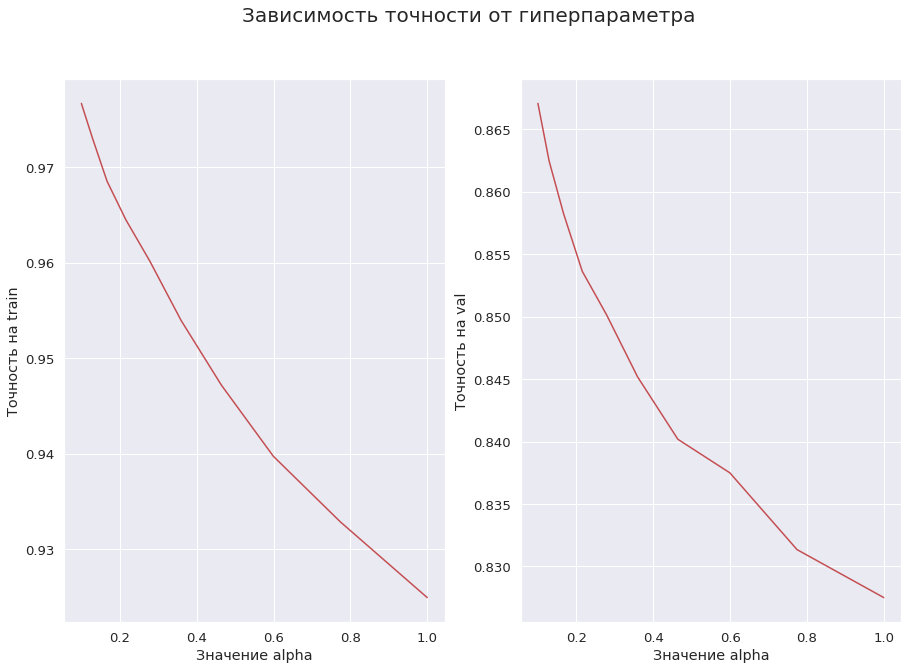

In [255]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes[0].plot(grid, hist_train, 'r')
axes[1].plot(grid, hist_val, 'r')

plt.suptitle("Зависимость точности от гиперпараметра", fontsize=20)

axes[0].set_xlabel("Значение alpha")
axes[0].set_ylabel(f"Точность на train")

axes[1].set_xlabel("Значение alpha")
axes[1].set_ylabel(f"Точность на val")

## Проверка

Посмотрим, как изменится точность при использовании более простых техник предобработки:

In [22]:
lemma = False
drop_mail = False

df = get_df(data_train)
df.data = df.data.apply(clean)

Text(0, 0.5, 'Точность на val')

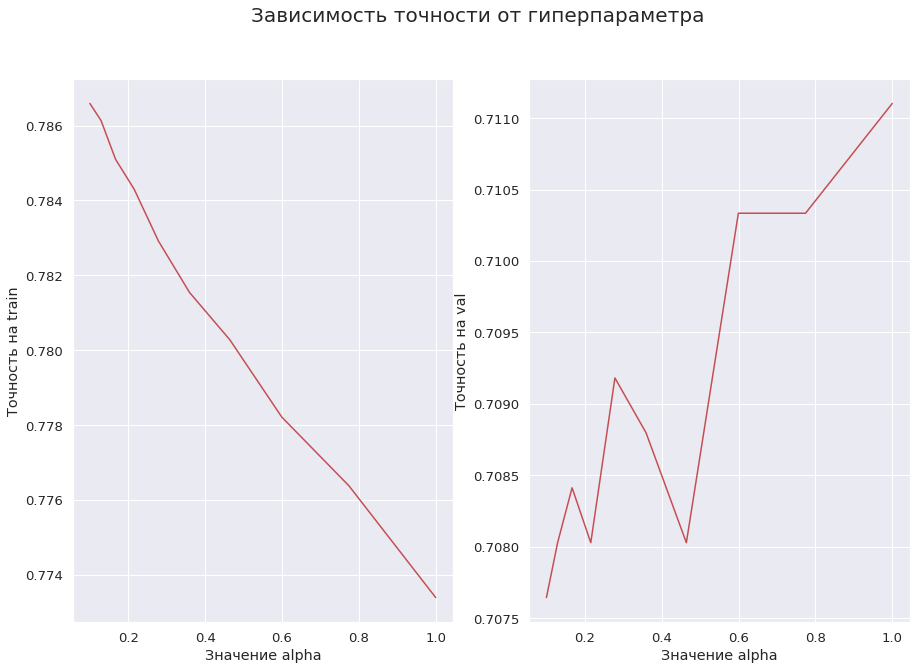

In [23]:
df_train, df_val = train_test_split(df, test_size=0.23, random_state=42, shuffle=True)
vectorizer = CountVectorizer(min_df=0.01, max_df=0.05, stop_words='english')
# vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
vec_data_train = vectorizer.fit_transform(df_train.data).toarray()
vec_data_val   = vectorizer.transform(df_val.data).toarray()

# print(len(vectorizer.get_feature_names()))
# print(vectorizer.get_feature_names())

grid = np.logspace(np.log10(0.1), np.log10(1), num=10)

hist_train = np.zeros((grid.shape[0], 1))
hist_val = np.zeros((grid.shape[0], 1))

for (i, alpha) in enumerate(grid):
    
    multinomial_nb = MultinomialNB(alpha = alpha)
    multinomial_nb.fit(vec_data_train, df_train.target)
    
    train_pred = multinomial_nb.predict(vec_data_train)
    val_pred = multinomial_nb.predict(vec_data_val)
    
    hist_train[i][0] = accuracy_score(df_train.target, train_pred)
    hist_val[i][0] = accuracy_score(df_val.target, val_pred)
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
axes[0].plot(grid, hist_train, 'r')
axes[1].plot(grid, hist_val, 'r')

plt.suptitle("Зависимость точности от гиперпараметра", fontsize=20)

axes[0].set_xlabel("Значение alpha")
axes[0].set_ylabel(f"Точность на train")

axes[1].set_xlabel("Значение alpha")
axes[1].set_ylabel(f"Точность на val")

Точность уменьшилась, а график на validate стал вести себя как-то странно. Адекватного объяснения этого природного явления у меня нет.

## GridSearch

Судя по графику, чем меньше alpha - тем лучше. Поэтому берем alpha=0.1

Обучим еще раз vectorizer и классификатор на полном train:

In [259]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
vec_data_train = vectorizer.fit_transform(df.data).toarray()

multinomial_nb = MultinomialNB(alpha = 0.1)
multinomial_nb.fit(vec_data_train, df.target)

MultinomialNB(alpha=0.1)

Считаем точность на тестовой выборке:

In [260]:
df_test = get_df(data_test)
df_test.data = df_test.data.apply(clean)
vec_data_test = vectorizer.transform(df_test.data).toarray()

In [261]:
preds = multinomial_nb.predict(vec_data_test)
print(f'Точность: {accuracy_score(df_test.target, preds) :.3}')

Точность: 0.793


Сделайте выводы.

- Байесовский классификатор позволяет добиться ~80% точности на наших данных. При этом мы постарались на этапе предобработки - так, например, лемматизация и удаление почт были нужны для уменьшения размерности полученных эмбеддингов в случае CountVectorizer.
- Сглаживание (alpha) только портит качество, оно нужно в т.ч. для борьбы c проблемой классификации на неизвестных словах, которых не было в train. Получается, мы хорошо предобработали данные и избавились от таких выбросов. Ну или датасет был сам по себе хороший.
- Точность модель зависит от способа векторизации слов.

---
# Задача 2.
Пусть $\mathscr{X} = \mathbb{R}^2$ — пространство признаков, $\mathscr{Y} = \{0, 1\}$ — множество классов. Рассматривается квадратичный дискриминантный анализ. Условное распределение $X$ при условии $Y=k$ равно $\mathcal{N}(a_k, \Sigma_k)$. Приведите примеры таких параметров $a_k, \Sigma_k$ и вероятностей $\mathsf{P}(Y = k)$, при которых разделяющая поверхность является
* гиперболой;
* параболой;
* двумя параллельными прямыми;
* двумя пересекающимися прямыми.

Напишем функции генерации и отрисовки.

In [3]:
def gen_data_(means, cov, means2, cov2, y):
    X = np.r_[
        sps.multivariate_normal(means, cov).rvs(size=(sample_size)),
        sps.multivariate_normal(means2, cov2).rvs(size=(sample_size))
    ]
    return X, y

def gen_data():
    return gen_data_(means, cov, means2, cov2, y)

def gen_data_fix():
    return gen_data_(means, cov, means, cov, y)

Я бы использовал функции с семинарского ноутбука, но они некрасивые. Мое чувство дизайна заставило меня позаимстовать и переделать функции отрисовки из документации scikit. Я думаю, не стоит воспринимать это как плагиат, т.к. отношения к теме это действие не несет.

In [7]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

"""
Very helpful plot function: https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html
"""

np.random.seed(42)

cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)

def plot_data(model, X, y):
    plot = plt.plot()
    
    X0, X1 = X[y == 0], X[y == 1]

    # class 0
    plt.scatter(X0[:, 0], X0[:, 1], marker=".", color="red")

    # class 1
    plt.scatter(X1[:, 0], X1[:, 1], marker=".", color="blue")

    nx, ny = 100, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 0.8), zorder=0.1
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.5, colors="white")
    return plot

In [5]:
def gen_plot(generator = gen_data):
    X, y = generator()
    qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    qda.fit(X, y)
    
    plt.figure(figsize=(10, 8), facecolor="white")
    plt.suptitle(
        "Quadratic Discriminant Analysis",
        y=0.98,
        fontsize=15,
    )


    plot_data(qda, X, y)
    plt.axis("tight")
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

### Пример с гиперболами:

/tmp/ipykernel_50975/1063340023.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(


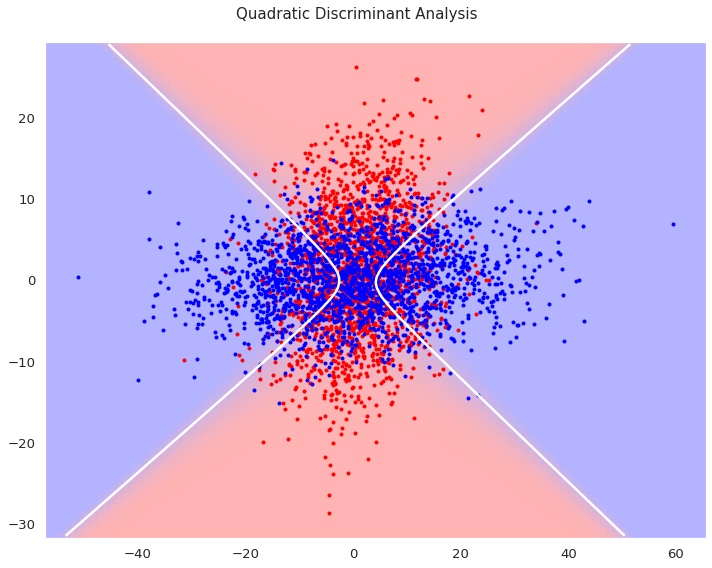

In [35]:
sample_size = 2000

means = np.array([1, 1])
cov = np.array([[2.0, 0.3], [0.3, 2.0]]) * 30

means2 = means * 0.2
cov2 = np.array([[11, 0.5], [0.5, 1]]) * 20

y = np.hstack((np.zeros(sample_size), np.ones(sample_size)))

gen_plot(gen_data)

Вероятности очевидны.

## Пример с параболой

/tmp/ipykernel_50975/1063340023.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(


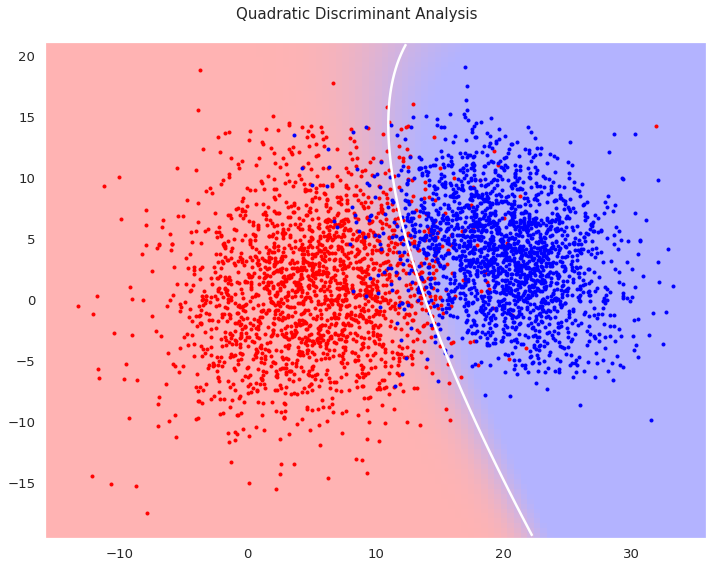

In [65]:
sample_size = 2000

means = np.array([5, 1])
cov = np.array([[2.0, 0.3], [0.3, 2.0]]) * 15

means2 = means * 4
cov2 = cov - 10

y = np.hstack((np.zeros(sample_size), np.ones(sample_size)))

gen_plot(gen_data)

Вероятности очевидны.

Здесь видно, что на стыке двух выборок у нас парабола (если уменьшить масштаб, QDA доведет разделяющую кривую до эллипса).

## Пример с двумя параллельными прямыми

/tmp/ipykernel_50975/1063340023.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(


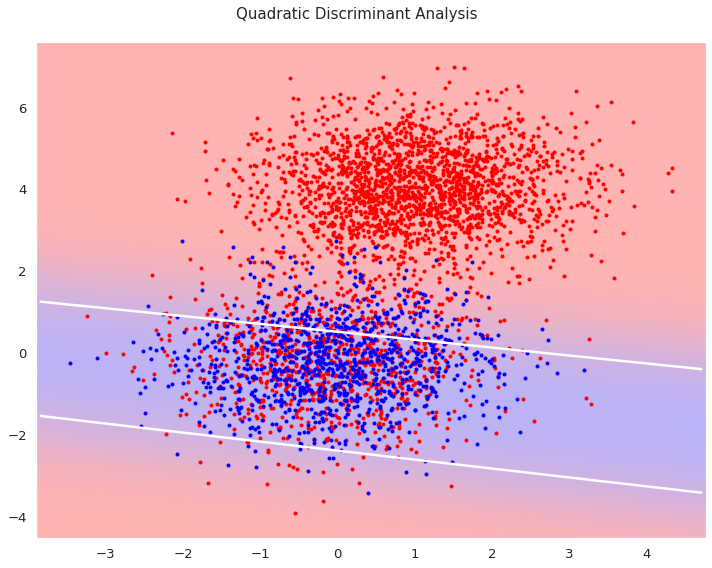

In [199]:
sample_size = 2000

means = np.array([1, 4])
cov = np.array([[1, 0], [0, 1]])

means2 = -means * 0.05
cov2 = np.array([[1, 0], [0, 1]])

y = np.hstack((
    np.zeros(sample_size),
    np.random.randint(100, size=sample_size) > 50,
    ))

gen_plot(gen_data)

Получилось!!!!! Но тут сложно считать вероятности. Поэтому:

/tmp/ipykernel_50975/1063340023.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(


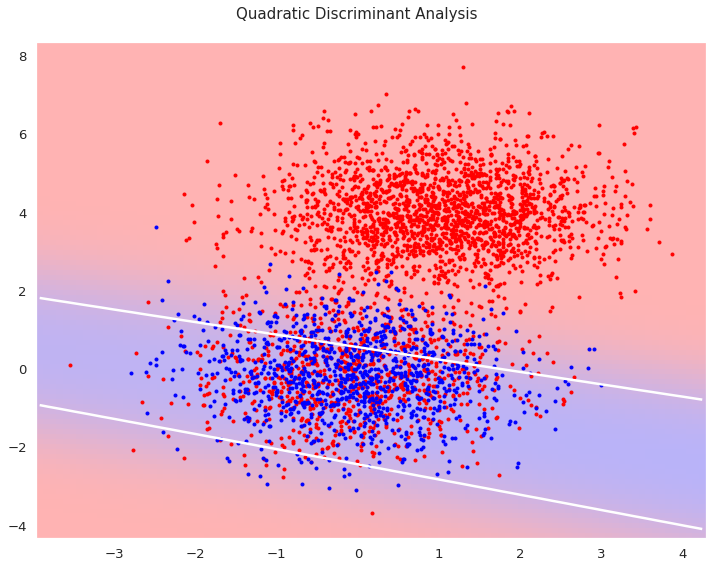

In [205]:
sample_size = 2000

means = np.array([1, 4])
cov = np.array([[1, 0], [0, 1]])

means2 = -means * 0.05
cov2 = np.array([[1, 0], [0, 1]])

y = np.hstack((
    np.zeros(sample_size),
    np.ones(sample_size),
    ))

gen_plot(gen_data)

Вероятности очевидны.

## Пример с двумя пересекающимися прямыми

/tmp/ipykernel_50975/1063340023.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(


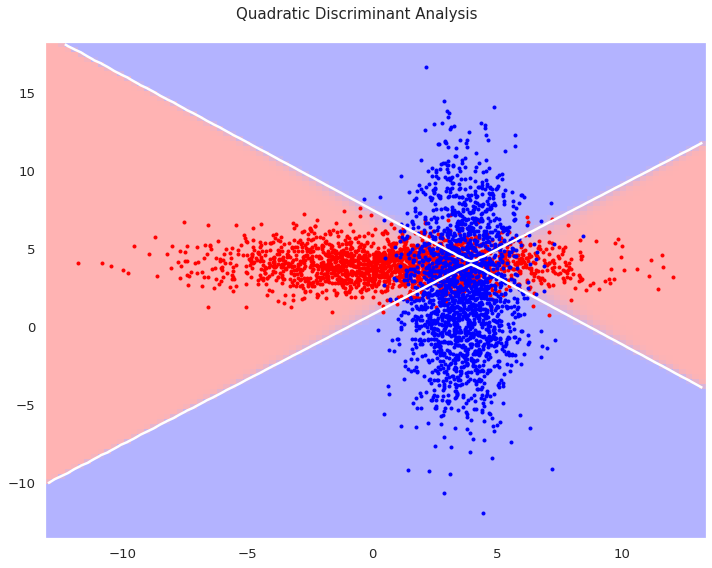

In [328]:
sample_size = 2000

means = np.array([1, 4])
cov = np.array([[12, 0], [0, 1]])

means2 = -means * 0.4 + 4
cov2 = np.array([[1, 0], [0, 11]]) * 1.4

y = np.hstack((
    np.zeros(sample_size),
    np.ones(sample_size),
    ))

gen_plot(gen_data)

/tmp/ipykernel_50975/1063340023.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(


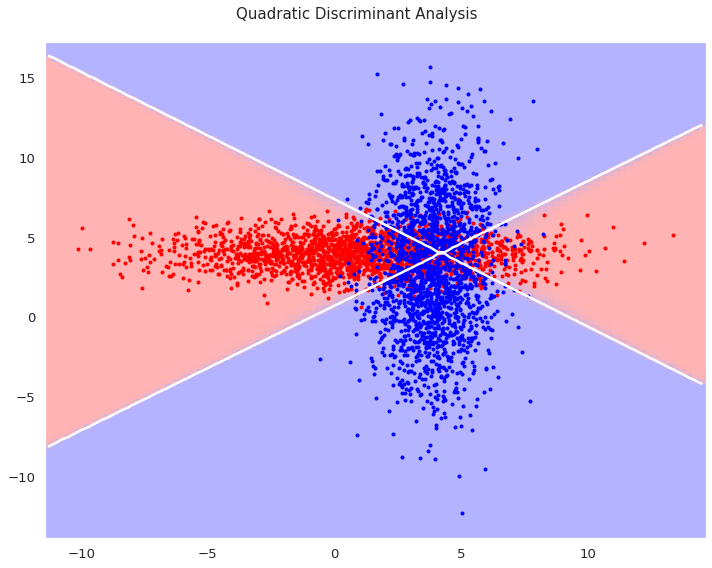

In [364]:
sample_size = 2000

means = np.array([1, 4])
cov = np.array([[12, 0], [0, 1]])

means2 = -means * 0.2 + 4
cov2 = np.array([[1, 0], [0, 11]]) * 1.49999

y = np.hstack((
    np.zeros(sample_size),
    np.ones(sample_size),
    ))

gen_plot(gen_data)

Где-то в пределе гиперболы выродятся в прямые...